In [1]:
import os
# Ignore my broken HDF5 install...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

In [2]:
import pandas as pd
import numpy as np
import iris
import cis
from cis.data_io.gridded_data import make_from_cube

import iris.quickplot as qplt
import cartopy.crs as ccrs
from tqdm import tqdm_notebook

from utils import get_aeronet_data, get_bc_ppe_data
from GCEm.gp_model import GPModel

import os

import matplotlib.pyplot as plt
%matplotlib inline

# GPU = "1"

# os.environ["CUDA_VISIBLE_DEVICES"] = GPU

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


# Read in the parameters and observables

In [3]:
# TODO: It would be nice to automate this somehow...
data_path = 'F:\\Local Data\\BC_PPE\\'

In [4]:
ppe_params, ppe_aaod = get_bc_ppe_data(data_path)

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))


In [5]:
# from GCEm.utils import get_weights

mean_aaod, = ppe_aaod.collapsed(['latitude', 'longitude', 'time'], 'mean')

C:\Users\duncan\miniconda3\envs\gcem_dev\lib\site-packages\iris\analysis\cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


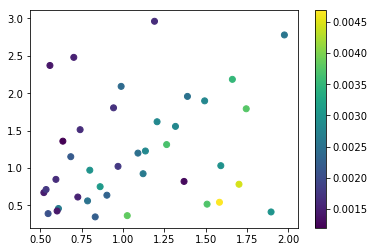

In [6]:
plt.scatter(ppe_params.BCnumber, ppe_params.Wetdep, c=mean_aaod.data)
plt.colorbar()

In [7]:
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

ppe_params = ppe_params.apply(normalize, axis=0)

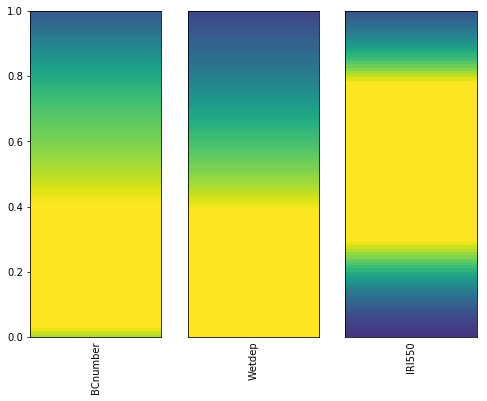

In [8]:
from GCEm.utils import plot_parameter_space

plot_parameter_space(ppe_params)

In [9]:
n_test = 8

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
Y_test, Y_train = mean_aaod[:n_test], mean_aaod[n_test:]

# Setup and run the models

In [10]:
model = GPModel(Y_train)

In [11]:
model.train(X_train)

In [12]:
m, v = model.predict(X_test.values)

Proportion of 'Bad' estimates : 0.00%


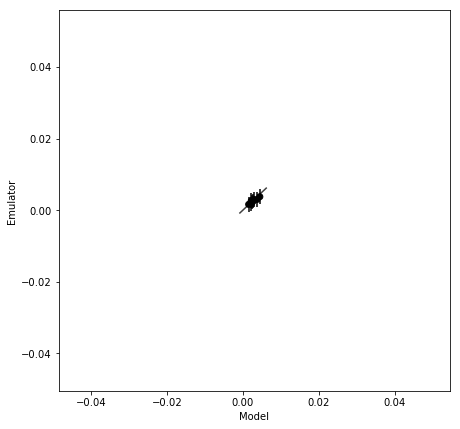

In [13]:
from GCEm.utils import validation_plot

validation_plot(Y_test.data.flatten(), m.data.flatten(), v.data.flatten())


In [14]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

prior_x = tfd.Uniform(low=tf.constant([0., 0., 0.], dtype=tf.float64), high=tf.constant([1., 1., 1.], dtype=tf.float64))
diff_dist = tfd.Normal(loc=tf.constant(0., dtype=tf.float64), scale=tf.constant(0.0001, dtype=tf.float64))

# prior = tfd.Uniform(low=tf.constant(0., dtype=tf.float64), high=tf.constant(1., dtype=tf.float64))

# prior = tfd.Independent(
#     tfd.Normal(loc=tf.constant(0., dtype=tf.float64), scale=tf.constant(1., dtype=tf.float64)),
#    reinterpreted_batch_ndims=1, name = 'model')


In [15]:
objective = tf.constant(Y_test[0].data, dtype=tf.float64)
print("Objective: {}".format(objective))

@tf.function
def target_log_likelihood(x):
    mean, _ = model._tf_predict(x)
    diff = tf.subtract(objective, mean[0])
    return prior_x.log_prob(x) + diff_dist.log_prob(diff)


def trace_log_accept_ratio(states, previous_kernel_results):
    return previous_kernel_results.log_accept_ratio

Objective: 0.002822510314728863


In [ ]:
tf.random.set_seed(42)

states, log_accept_ratio = tfp.mcmc.sample_chain(
    num_results=5000,
    num_burnin_steps=1000,
    current_state=tf.ones((1, 3), dtype='float64')*0.5,
    parallel_iterations=1,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_likelihood,
        step_size=0.01,
        num_leapfrog_steps=5),
#     kernel=tfp.mcmc.RandomWalkMetropolis(
#         target_log_prob_fn=target_log_likelihood),
    trace_fn=trace_log_accept_ratio)

sample_stddev = tf.math.reduce_std(states)
acceptance_prob = tf.math.exp(tf.minimum(log_accept_ratio, 0.))
sample_mean = tf.reduce_mean(states, axis=0)

In [ ]:
print(acceptance_prob.numpy().mean())

In [ ]:
Xs = states.numpy().T
new_samples = pd.DataFrame(data=Xs.T[:,0,:], columns=ppe_params.columns)
m, _ = model._tf_predict(new_samples.values)
Zs = m.numpy()[:, 0]

In [ ]:
print("Sample mean: {}".format(Zs.mean()))
print("Sample std dev: {}".format(Zs.std()))

In [ ]:
plot_parameter_space(new_samples, target_df=X_test.iloc[0])

In [ ]:
grr = pd.plotting.scatter_matrix(new_samples, c=Zs, figsize=(12, 12), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8, vmin=1e-3, vmax=5e-3)

In [ ]:
from GCEm.sampler import ABCSampler, constrain
from GCEm.utils import get_random_params

In [ ]:
from iris.cube import Cube
sample_points = pd.DataFrame(get_random_params(3, int(1e4)), columns=ppe_params.columns)
sampler = ABCSampler(model, Y_test[0:1])

implaus = sampler.get_implausibility(sample_points.values, batch_size=100)

In [ ]:
valid_samples = constrain(implaus.data.reshape(-1, 1), threshold=0.5)
valid_points = sample_points[valid_samples.numpy()]

In [ ]:
m, _ = model._tf_predict(valid_points.values)
Zs = m.numpy()[:, 0]

In [ ]:
print("Sample mean: {}".format(Zs.mean()))
print("Sample std dev: {}".format(Zs.std()))

In [ ]:
plot_parameter_space(valid_points, target_df=X_test.iloc[0])

In [ ]:
grr = pd.plotting.scatter_matrix(valid_points, c=Zs, figsize=(12, 12), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8, vmin=1e-3, vmax=5e-3)